<a href="https://colab.research.google.com/github/joshmurr/machine-learnings/blob/master/cci-dsai/Simple_GAN_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple GAN to Model a Given Distribution

This notebook is mostly to make it easier to see the structure of a GAN in code by keeping the model size small. As GANs get bigger and more complex the details can get lost in a sea of code.

It is also small enough that it trains quickly, and so you can can play with the parameters of the model to see how it affects training like: number of layers in the generator or discriminator; size of the input latent vector; a different formula to generate the data; number of epoch; batch size etc.

First some imports:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tensorflow import keras

The function `calculate()` below is the function we will use the generate the _real_ data. This, in effect, becomes our _dataset_.

The 3D graph plotted below shows the _shape_ of our dataset. This is something you cannot easily do with complex, high-dimensional data like images.

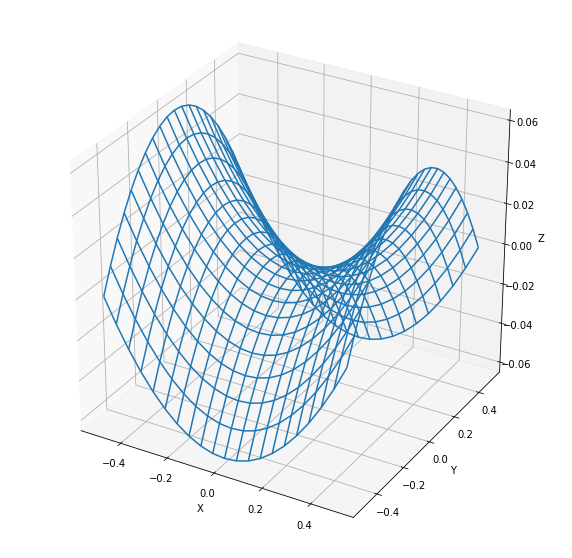

In [2]:
# The function below will be used to generate our training data.

def calculate(x, y):
    a = 2
    b = 2
    l = x**2 / a**2
    r = y**2 / b**2
    return l - r


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-0.5, 0.55, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(calculate(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

ax.plot_wireframe(X, Y, Z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.savefig('function.png')

plt.show()

Below are some helper functions which should be fairly self explanatory.

In [3]:
# 'Real Samples' are samples from the dataset
def generate_real_samples(n=100):
    X1 = np.random.rand(n) - 0.5
    Y1 = np.random.rand(n) - 0.5
    Z1 = calculate(X1, Y1)
    X1 = X1.reshape(n, 1) 
    Y1 = Y1.reshape(n, 1)
    Z1 = Z1.reshape(n, 1)
    X = np.hstack((X1, Y1, Z1)) # Stacks 'column-wise'
    
    y = np.ones((n, 1)) # 1 is the 'real' label

    # X shape = (n, 3)
    # y shape = (n, 1)
    return X, y

In [4]:
# 'Latent Points' are inputs to the generator
def generate_latent_points(latent_dim, n):
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [5]:
# 'Fake Samples' are the output of the generator (fake according to D)
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)

    y = np.zeros((n, 1)) # 0 is the 'fake' label
    
    return X, y

## Defining the Discriminator (__D__)

__D__ is a simply fully connected neural network. Here you can play with the number of layers or number or neurons in each layer. It might have a knock on effect down the line, ie a deeper network might need a larger dataset, or larger batchsizes etc.

The output of __D__ is a single scalar value of the range [0, 1] as per the _sigmoid_ activiation on the last layer.

In [6]:
def define_discriminator(n_inputs=3):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        35,
        activation='relu',
        kernel_initializer='he_uniform',
        input_dim=n_inputs
    ))
    model.add(keras.layers.Dense(
        25,
        activation='relu',
        kernel_initializer='he_uniform',
    ))
    model.add(keras.layers.Dense(
        1,
        activation='sigmoid',
    ))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

## Defining the Generator (__G__)

__G__ is an equally simple neural network which takes a vector input which will be our latent vector __Z__.

The output of __G__ is a vector of length 3. The 'linear' activation is effectively a 'pass-through' in that it does not scale the data at all - it gives us a real value.

Note that we do not compile __G__ here as we will do that when we put the model together as whole. (This is not standard practice, but will make sense later on in the training loop).

In [7]:
def define_generator(latent_dim, n_outputs=3):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        25,
        activation='relu',
        kernel_initializer='he_uniform',
        input_dim=latent_dim
    ))
    model.add(keras.layers.Dense(
        35,
        activation='relu',
        kernel_initializer='he_uniform',
    ))
    model.add(keras.layers.Dense(
        n_outputs,
        activation='linear',
    ))
    return model

## Making the GAN

Here we put __D__ and __G__ together to make the __GAN__!

Notice that we set `discriminator.trainable = False`. This is so that when we run the GAN as a whole __D__ is not trained but __G__ is - we can train __D__ separately.

In [8]:
# We define the model as a whole (G and D combined) and set D->trainable to False
# so that only G trains on the gradients produced by D. We explicitly train D
# in the training loop later on.
def define_GAN(generator, discriminator):
    discriminator.trainable = False
    model = keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

This is just a helper function which we can use to plot the output of our __G__ during training.

Inside the function __G__ is used to generate some samples which overlaid onto the desired distribution (the saddle-shaped graph).

In [9]:
def summarise_performance(epoch, generator, discriminator, latent_dim, n=100, save_fig=False, display=['fake']):
    """
        A helper function to analyse and view the performace of the model in training.
    """
    x_real, y_real = generate_real_samples(n)
    #_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    #_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z)
    
    if 'real' in display:
      ax.scatter(x_real[:, 0], x_real[:, 1], x_real[:, 2], c='red', marker='o')
    if 'fake' in display:
      ax.scatter(x_fake[:, 0], x_fake[:, 1], x_fake[:, 2], c='blue', marker='x')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if save_fig:
        plt.savefig(f'{epoch:05}.png')


    plt.show()

In [23]:
latent_dim = 10
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_GAN(generator, discriminator)

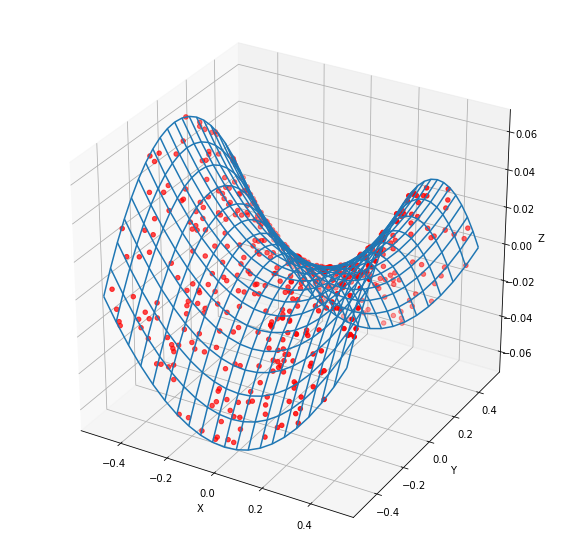

In [13]:
# Before we start we can plot a sample of 'real' data and see how it lies on the
# desired distribution..
summarise_performance(15000, generator, discriminator, latent_dim, n=500, display=['real'])

## Training

This is hopefully where keeping the model size small makes the training loop nice and clear.

In each training step we use our helper functions from the top to generate a batch of real and fake data.

Then we train __D__ in two stages, once on real data, once on fake data.

After we train __G__. Remember earlier when we compiled the GAN as a whole we set `discriminator.trainable = False`? That allows us to call `gan_model.train_on_batch()` and know that only __G__ will be trained.

Finally we call our `summarise_performance()` function to give us some visual output of how the model is training.

In [16]:
def train(g_model, d_model, gan_model,
          latent_dim, n_epochs=100, n_batch=128, n_eval=50
        ):
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # Here we train D first on a real batch and then a fake batch
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        x_gen = generate_latent_points(latent_dim, n_batch)
        y_gen = np.ones((n_batch, 1))
        # Here we are only training G as D is frozen (see above)
        gan_model.train_on_batch(x_gen, y_gen)
        if (i+1) % n_eval == 0:
            summarise_performance(i, g_model, d_model, latent_dim)

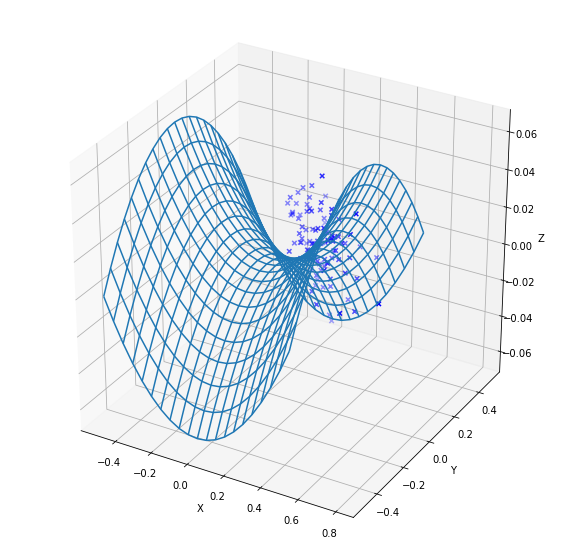

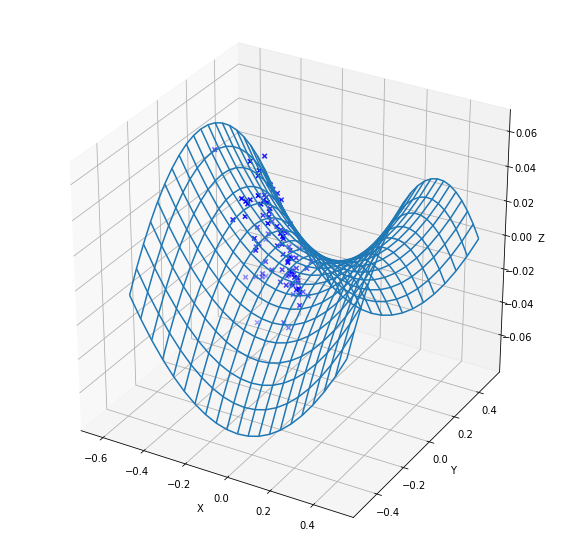

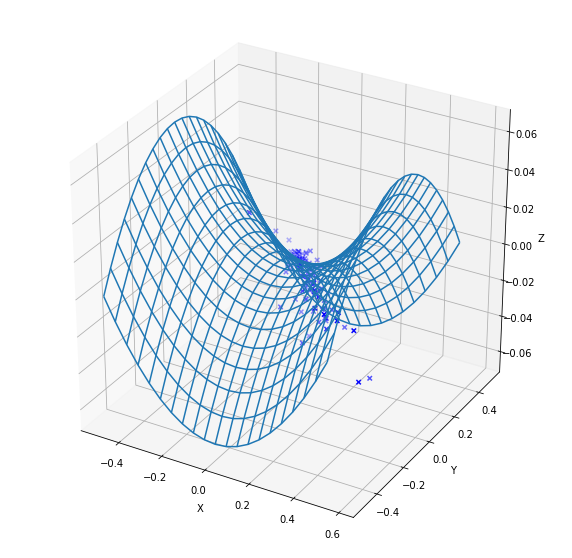

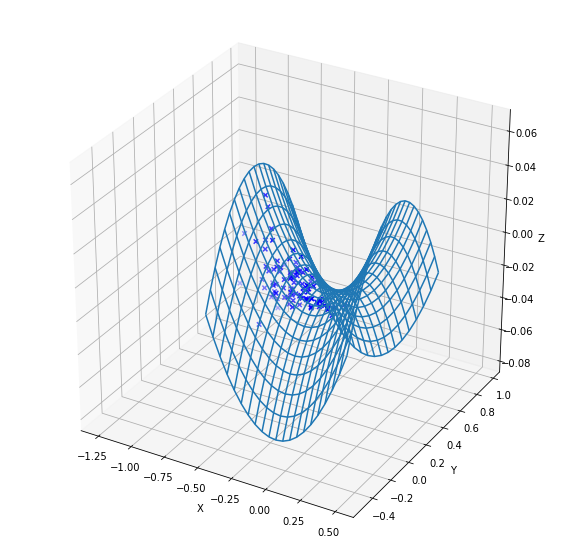

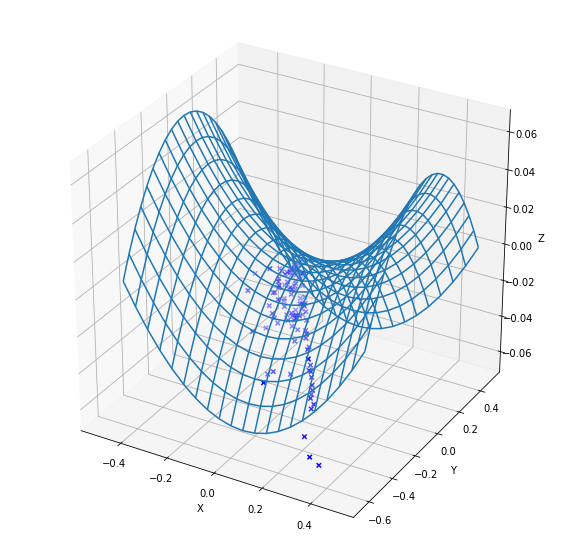

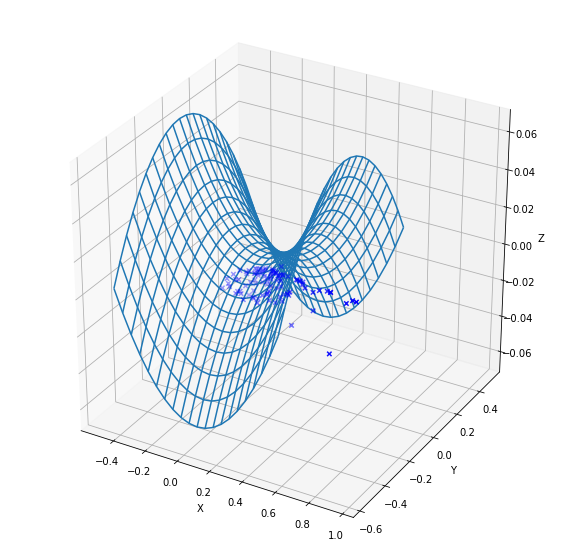

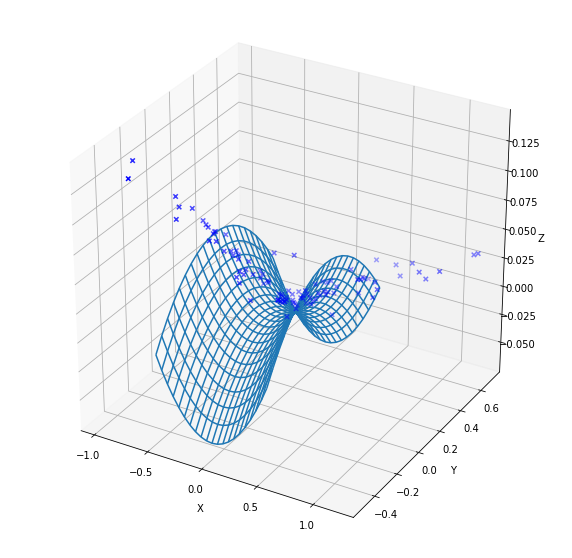

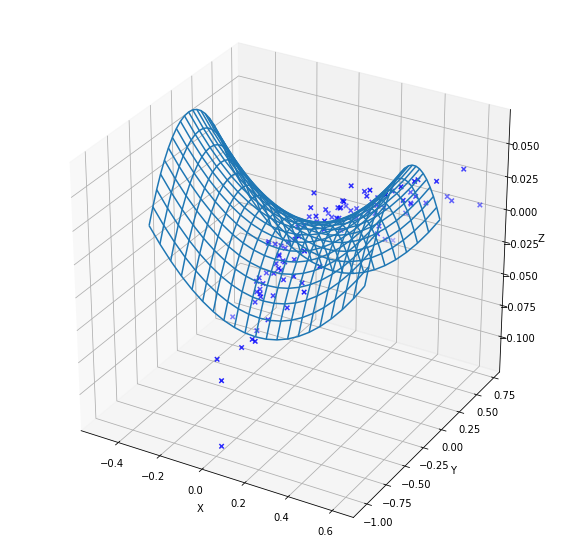

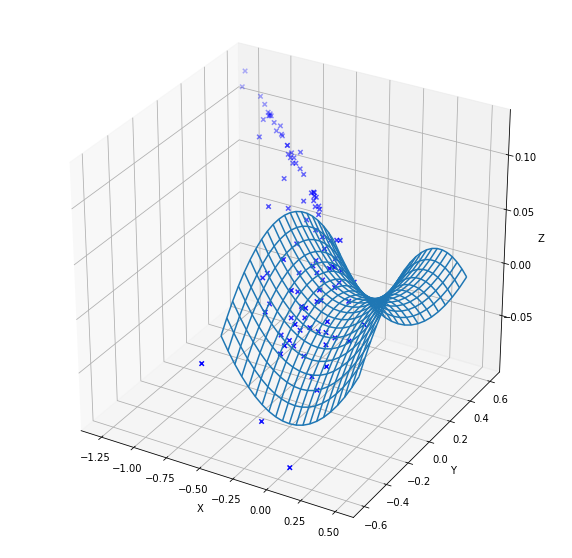

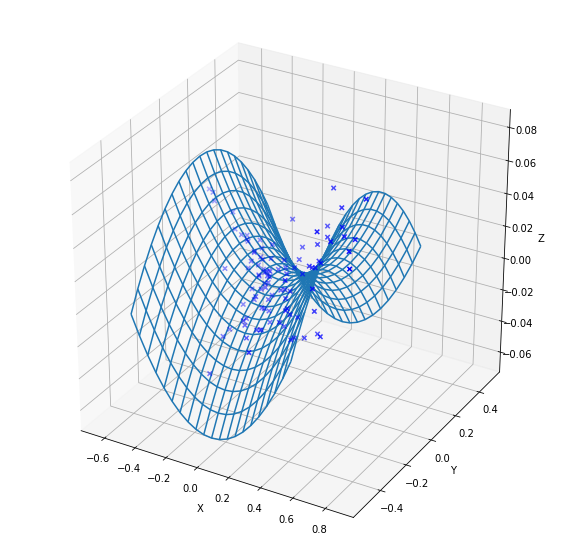

In [25]:
train(generator, discriminator, gan_model, latent_dim, n_epochs=1000, n_eval=100)

In [ ]:
summarise_performance(15000, generator, discriminator, latent_dim, n=500, display=['fake'])

## Inspecting Our Model

Now that it is trained we can use the `summarise_performance()` function to plot a number of data samples as produced by __G__ and hopefully see that the distribution of generator matches that of the desired distribution!

Or maybe not? Play with some of the parameters of the model and see what the effects are. You might observe _mode collapse_ where __G__ will produce lots of very similar data samples and fail to generalise.

15000 0.4339999854564667 0.6779999732971191


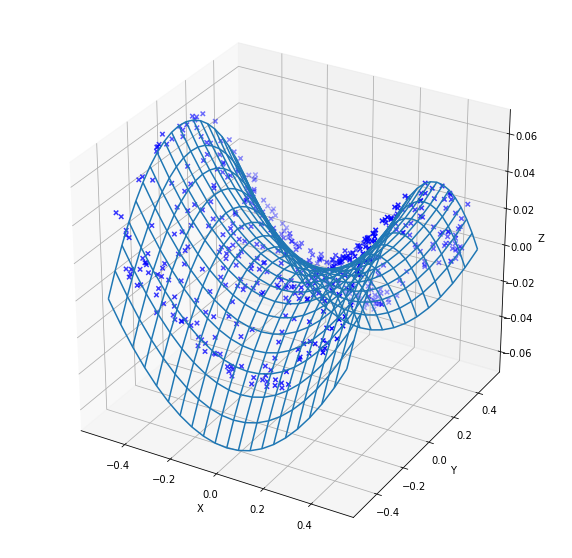

In [ ]:
# Now if we plot a sample from G we should see that 
# it's not far off the desired distribution...
summarise_performance(15000, generator, discriminator, latent_dim, n=500, display=['fake'])

## Extra: Animated Graphs



In [ ]:
def output(name, generator, x_input, save_fig=True):
  """
  A simplified version of summarise_performance() which just displays output from G
  and saves the image.
  """ 
  x_fake = generator.predict(x_input)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_wireframe(X, Y, Z)
  ax.scatter(x_fake[:, 0], x_fake[:, 1], x_fake[:, 2], c='blue', marker='x')

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  if save_fig:
    plt.savefig(f'./{name}.png')

  plt.show()

  return x_fake

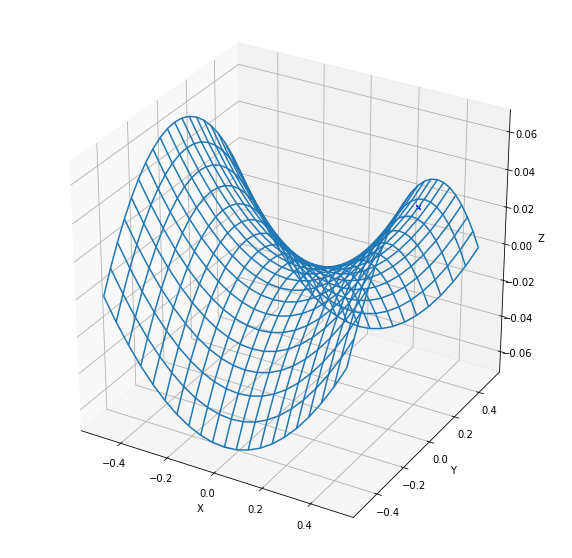

Input Latent Vector: [[-0.044 -2.105 -0.044  0.949  0.647  0.605  0.217  0.215  0.895 -0.596]]
Output Vec from G: [[0.401 0.195 0.037]]


In [ ]:
input_vec = np.random.randn(latent_dim)
input_vec = input_vec.reshape(1, latent_dim)

output_coords = output('single-point2', generator, input_vec)

print(f"Input Latent Vector: {np.around(input_vec, decimals=3)}")
print(f"Output Vec from G: {np.around(output_coords, decimals=3)}")

In [ ]:
# uniform interpolation between two points in latent space
# https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

In [ ]:
#https://medium.com/@pnpsegonne/animating-a-3d-scatterplot-with-matplotlib-ca4b676d4b55

import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters

def make_animation(data, title=None, save=False):
    """
    Creates the 3D figure and animates it with the input data.
    Args:
        data (list): List of the data positions at each iteration.
        save (bool): Whether to save the recording of the animation. (Default to False).
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:], c='blue', marker='x') for i in range(data[0].shape[0]) ]
    iterations = len(data)
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    if not title:
        title = "Sample Video"
    ax.set_title(title)
    ax.plot_wireframe(X, Y, Z)
    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                       interval=50, blit=False, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
        ani.save(f"{title.lower().replace(' ', '-')}.mp4", writer=writer)

    plt.show()

In [ ]:
# 1. Generate two latent vectors (A & B) and interpolate between them.
# 2. Run the interpolated vectors through G to obtain the interpolation in
#    output space (3D Coords)
A = np.random.randn(latent_dim)
B = np.random.randn(latent_dim)
points = interpolate_points(A, B, n_steps=80)
coords = [generator.predict(p.reshape(1, latent_dim)) for p in points]

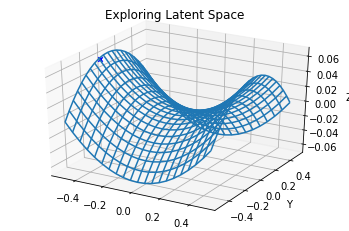

In [ ]:
# 3. Make an animation using these 3D coords and save the video.
make_animation(coords, title="Exploring Latent Space", save=True)